In [90]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

import src.utils.setup_figures as figures
import src.utils.basic as utils


In [92]:
from config import dir_config, main_config

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)


data = pd.read_csv(Path(processed_dir, "processed_data.csv"), index_col=None)

processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata.csv"), index_col=None)
# exclude the following subjects where categorization score is more than 2
reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 2]['subject_id']
processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]


In [93]:
# Getting indices of on and off treatment from same subject in processed metadata
subject_treatment_idx = pd.DataFrame(columns=['subject', 'off', 'on'])
subtype_idx = pd.DataFrame(columns=['subject', 'off', 'on'])

for idx, sub in enumerate(processed_metadata['subject_id'].unique()):
    sub_df = processed_metadata.loc[processed_metadata['subject_id'] == sub]
    subject_treatment_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

    if np.sum(np.isnan(sub_df['categorization_score'])) == 0:
        # put off treatment first column and on treatment second column one row at a time
        subtype_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]
        

### Psychometric Function plots

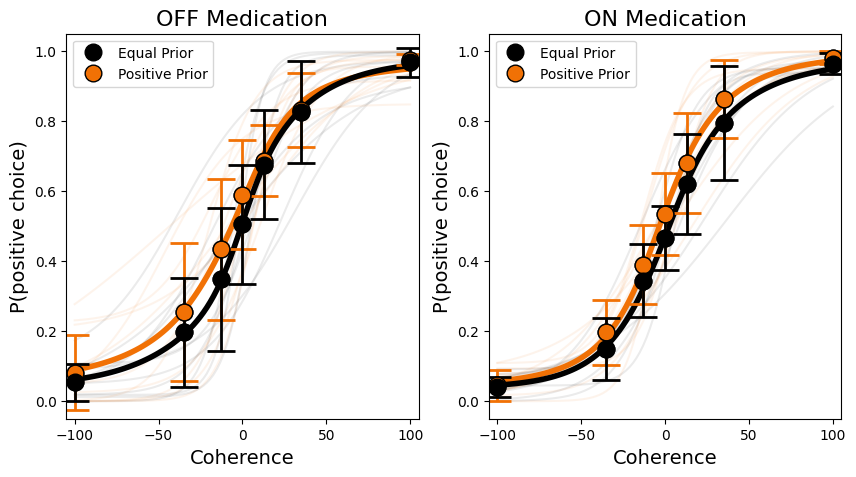

In [128]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
subject_alpha = 0.08
positive_color = 'C5'
equal_color = 'black'
error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

sub_off_pos_coh, sub_off_pos_psych, sub_off_pos_model, sub_off_pos_x_hat, sub_off_pos_y_hat = [], [], [], [], []
sub_off_eq_coh, sub_off_eq_psych, sub_off_eq_model, sub_off_eq_x_hat, sub_off_eq_y_hat = [], [], [], [], []
sub_on_pos_coh, sub_on_pos_psych, sub_on_pos_model, sub_on_pos_x_hat, sub_on_pos_y_hat = [], [], [], [], []
sub_on_eq_coh, sub_on_eq_psych, sub_on_eq_model, sub_on_eq_x_hat, sub_on_eq_y_hat = [], [], [], [], []

# subjects = subject_treatment_idx['subject'].unique()
subjects = subtype_idx['subject'].unique()


for i, subject in enumerate(subjects):
    subject_data = data[data['subject'] == subject]
    subject_data = subject_data.sort_values('medication')
    
    subject_metadata = processed_metadata.loc[processed_metadata['subject_id'] == subject]
    if True and np.sum(np.isnan(subject_metadata['categorization_score'])) == 0:
    
        for idx, med in enumerate(subject_data['medication'].unique()):
            med_data = subject_data[subject_data['medication'] == med]
            pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat = utils.get_psychometric_data(med_data[med_data['color'] == 1])
            eq_coh, eq_psych, eq_model, eq_x_hat, eq_y_hat = utils.get_psychometric_data(med_data[med_data['color'] == -1])

            if med == 'off':            
                ax_idx = 0
                sub_off_pos_coh.append(pos_coh)
                sub_off_pos_psych.append(pos_psych)
                sub_off_pos_model.append(pos_model)
                sub_off_pos_x_hat.append(pos_x_hat)
                sub_off_pos_y_hat.append(pos_y_hat)            
                sub_off_eq_coh.append(eq_coh)
                sub_off_eq_psych.append(eq_psych)
                sub_off_eq_model.append(eq_model)
                sub_off_eq_x_hat.append(eq_x_hat)
                sub_off_eq_y_hat.append(eq_y_hat)
            elif med == 'on':            
                ax_idx = 1
                sub_on_pos_coh.append(pos_coh)
                sub_on_pos_psych.append(pos_psych)
                sub_on_pos_model.append(pos_model)
                sub_on_pos_x_hat.append(pos_x_hat)
                sub_on_pos_y_hat.append(pos_y_hat)
                sub_on_eq_coh.append(eq_coh)
                sub_on_eq_psych.append(eq_psych)
                sub_on_eq_model.append(eq_model)
                sub_on_eq_x_hat.append(eq_x_hat)
                sub_on_eq_y_hat.append(eq_y_hat)
            
            ax[ax_idx].plot(pos_coh, pos_psych, color=positive_color, ls='', alpha=subject_alpha)
            ax[ax_idx].plot(pos_x_hat, pos_y_hat, color=positive_color, ls='-', alpha=subject_alpha)
            ax[ax_idx].plot(eq_coh, eq_psych, color=equal_color, ls='', alpha=subject_alpha)
            ax[ax_idx].plot(eq_x_hat, eq_y_hat, color=equal_color, ls='-', alpha=subject_alpha)


ax[0].plot(np.mean(sub_off_pos_x_hat, axis=0), np.mean(sub_off_pos_y_hat, axis=0), color=positive_color, ls='-', lw=4, alpha=1)
ax[0].plot(np.mean(sub_off_eq_x_hat, axis=0), np.mean(sub_off_eq_y_hat, axis=0), color=equal_color, ls='-', lw=4, alpha=1)
ax[0].errorbar(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), yerr=np.std(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
ax[0].errorbar(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), yerr=np.std(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Positive Prior', alpha=1)

ax[1].plot(np.mean(sub_on_pos_x_hat, axis=0), np.mean(sub_on_pos_y_hat, axis=0), color=positive_color, ls='-', lw=4, alpha=1)
ax[1].plot(np.mean(sub_on_eq_x_hat, axis=0), np.mean(sub_on_eq_y_hat, axis=0), color=equal_color, ls='-', lw=4, alpha=1)
ax[1].errorbar(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), yerr=np.std(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
ax[1].errorbar(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), yerr=np.std(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Positive Prior', alpha=1)

ax[0].set_title(f"OFF Medication", fontsize=16)
ax[0].set_xlabel('Coherence', fontsize=14)
ax[0].set_ylabel('P(positive choice)', fontsize=14)
ax[0].set_xlim(-105, 105)
ax[0].set_ylim(-0.05, 1.05)
ax[0].legend()
ax[1].set_title(f"ON Medication", fontsize=16)
ax[1].set_xlabel('Coherence', fontsize=14)
ax[1].set_ylabel('P(positive choice)', fontsize=14)
ax[1].set_xlim(-105, 105)
ax[1].set_ylim(-0.05, 1.05)
ax[1].legend()

### Perform analysis on bias, alpha, beta, gamma and delta based on categorization_score

In [71]:
print(processed_metadata.loc[subtype_idx['off']]['categorization_score'])
print(processed_metadata.loc[subtype_idx['on']][f'equal_{independent_variable}'])
print(processed_metadata.loc[subtype_idx['off']][f'equal_{independent_variable}'])
print(processed_metadata.loc[subtype_idx['on']][f'equal_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'equal_{independent_variable}'].values)

0     0.000000
2     0.612245
5     0.451128
7     0.833333
9     1.200000
10    0.000000
15    0.918367
17    0.238095
18    0.000000
21    0.252101
22    0.714286
Name: categorization_score, dtype: float64
1     0.400000
3     0.537500
4     0.417722
6     0.392405
8     0.519481
11    0.569620
14    0.272727
16    0.468354
19    0.562500
20    0.410256
23    0.576923
Name: equal_bias, dtype: float64
0     0.414286
2     0.683544
5     0.825000
7     0.346667
9     0.582278
10    0.512500
15    0.324675
17    0.662500
18    0.587500
21    0.287500
22    0.333333
Name: equal_bias, dtype: float64
[-0.01428571 -0.1460443  -0.40727848  0.0457384  -0.06279796  0.05712025
 -0.05194805 -0.19414557 -0.025       0.12275641  0.24358974]


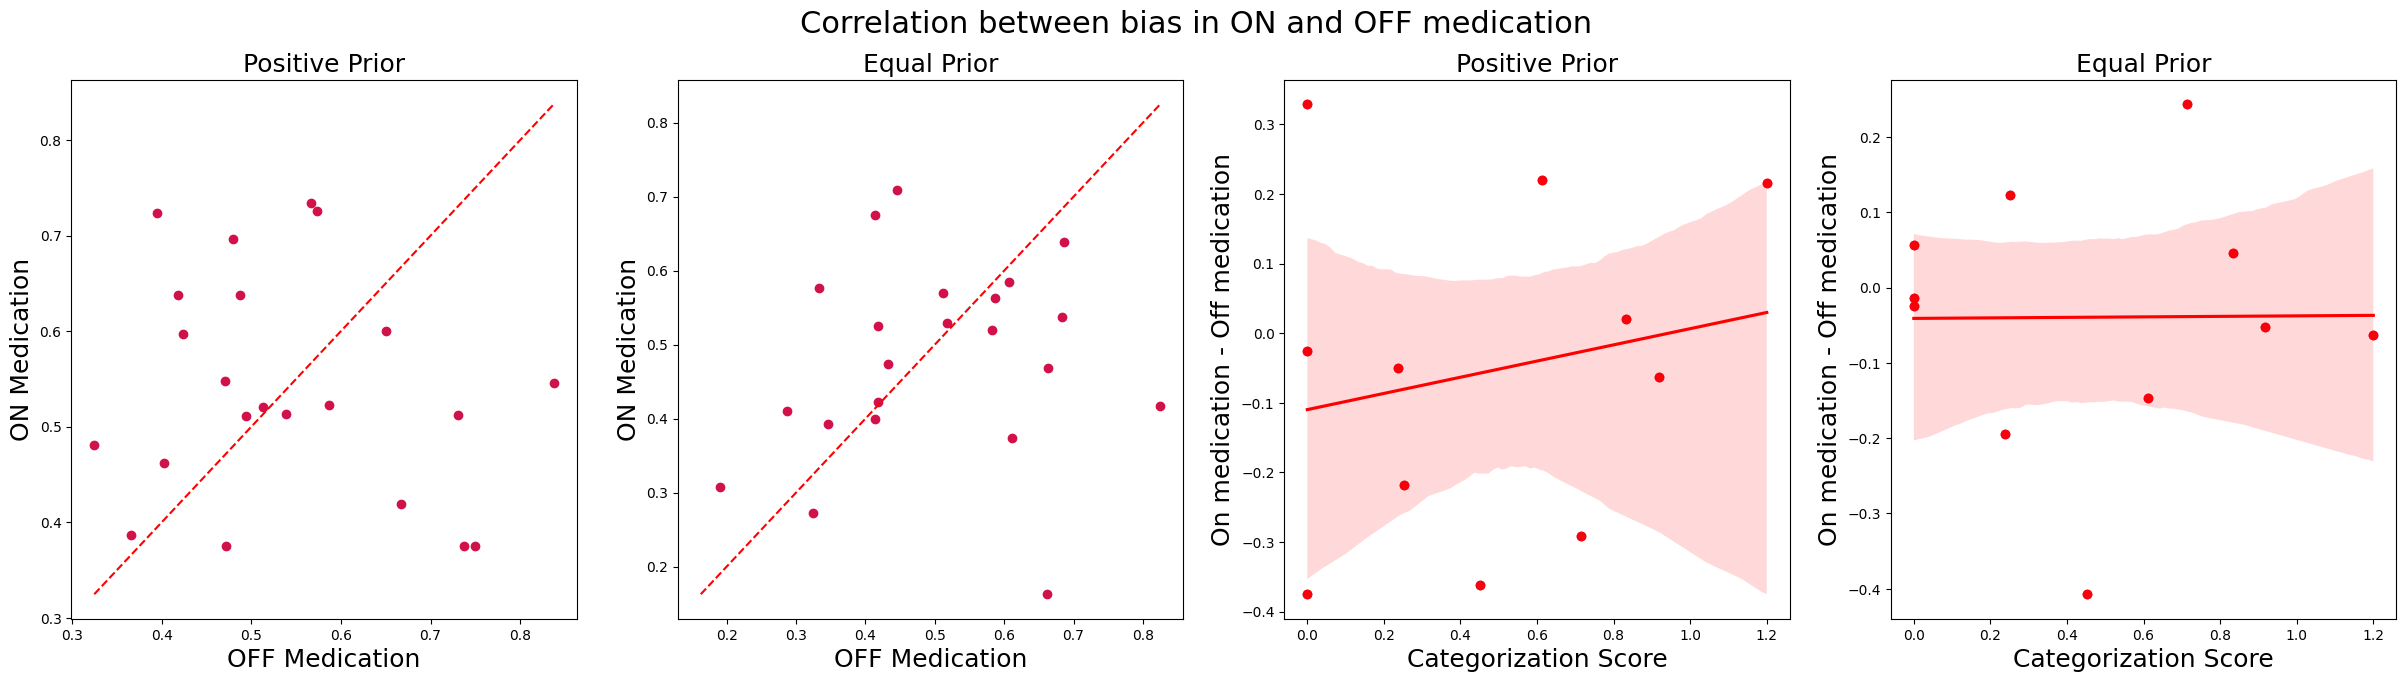

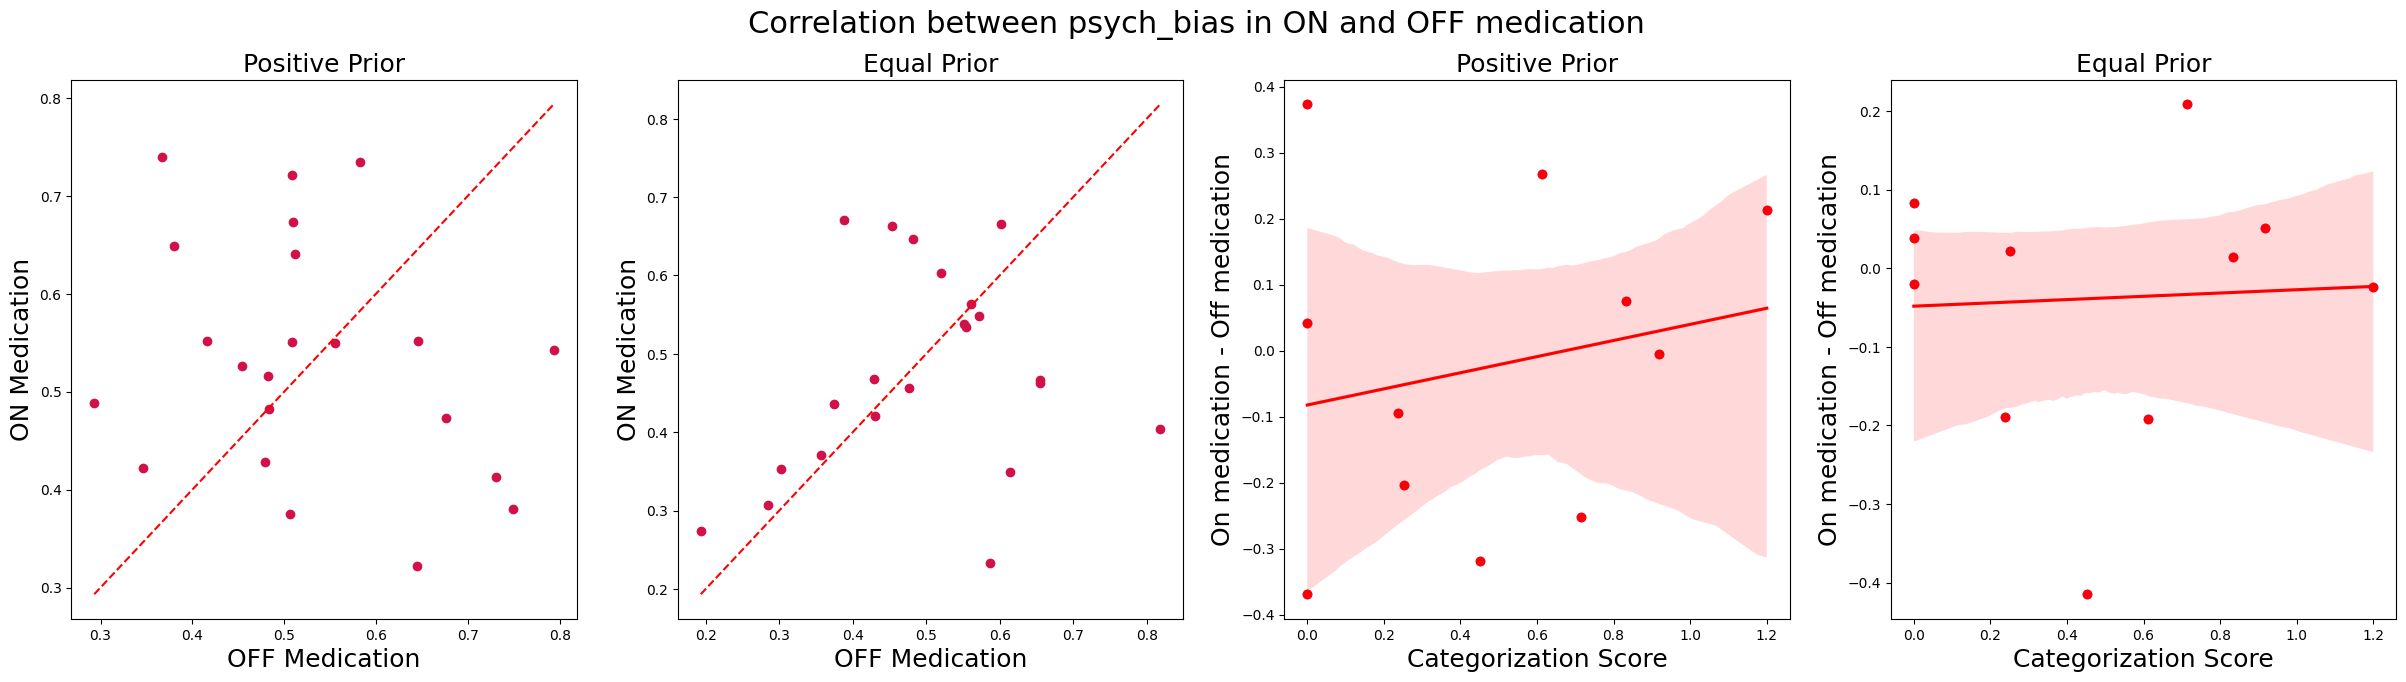

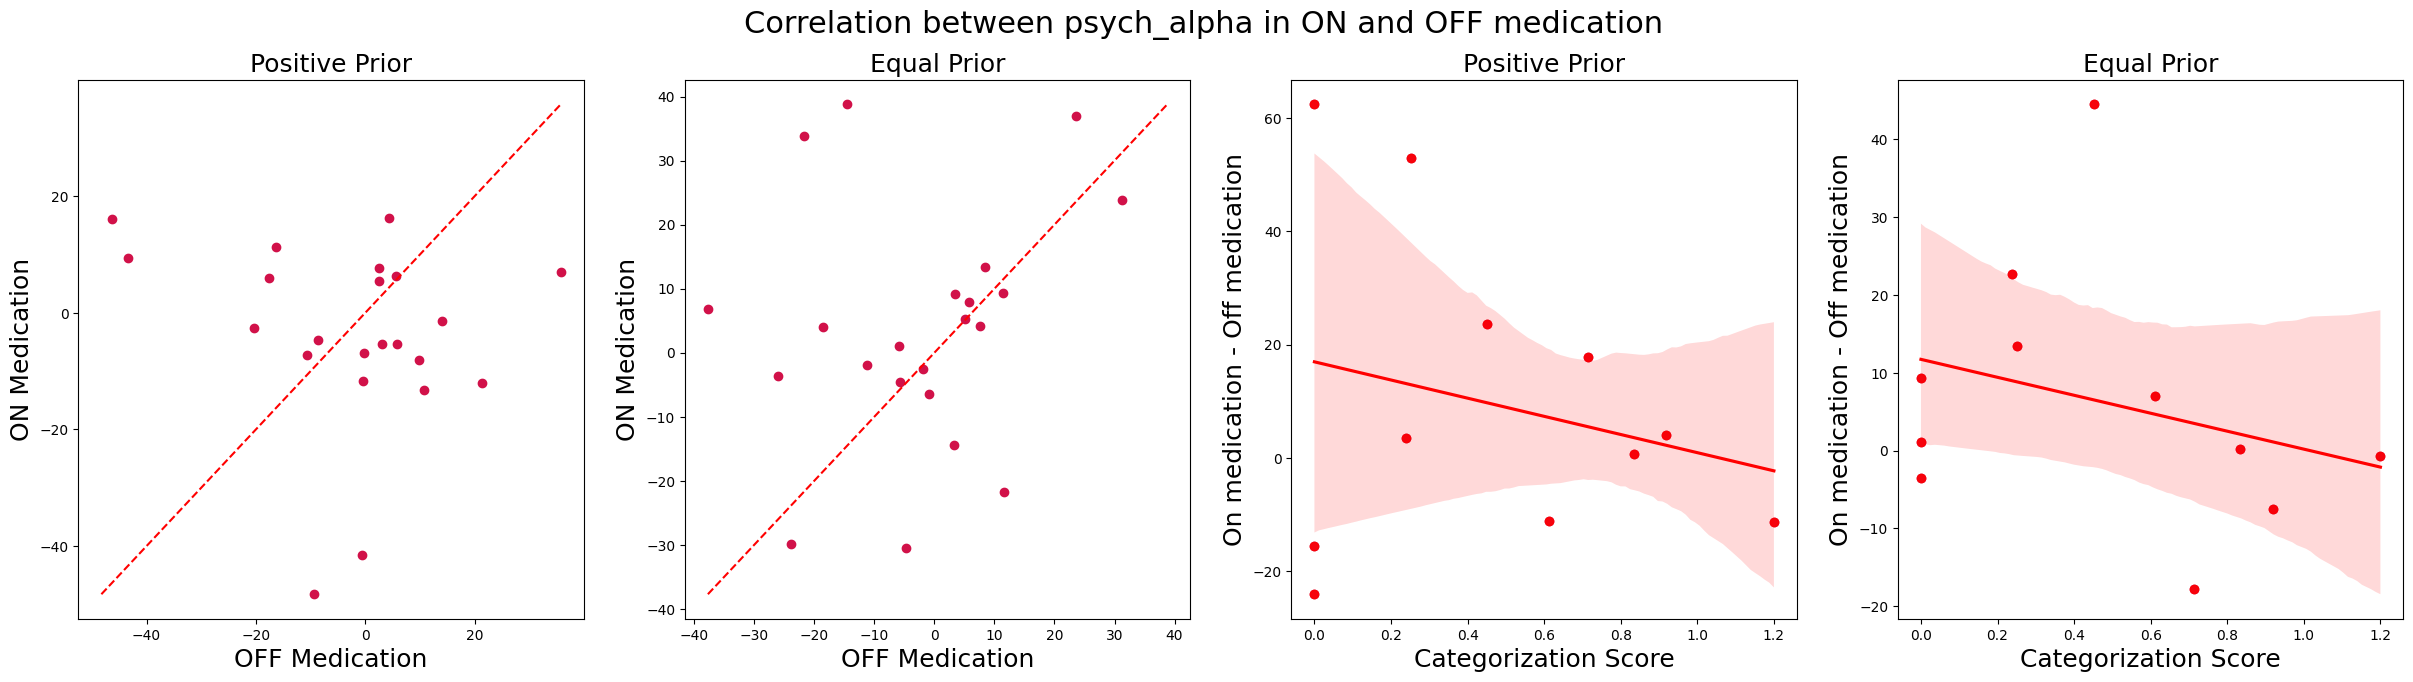

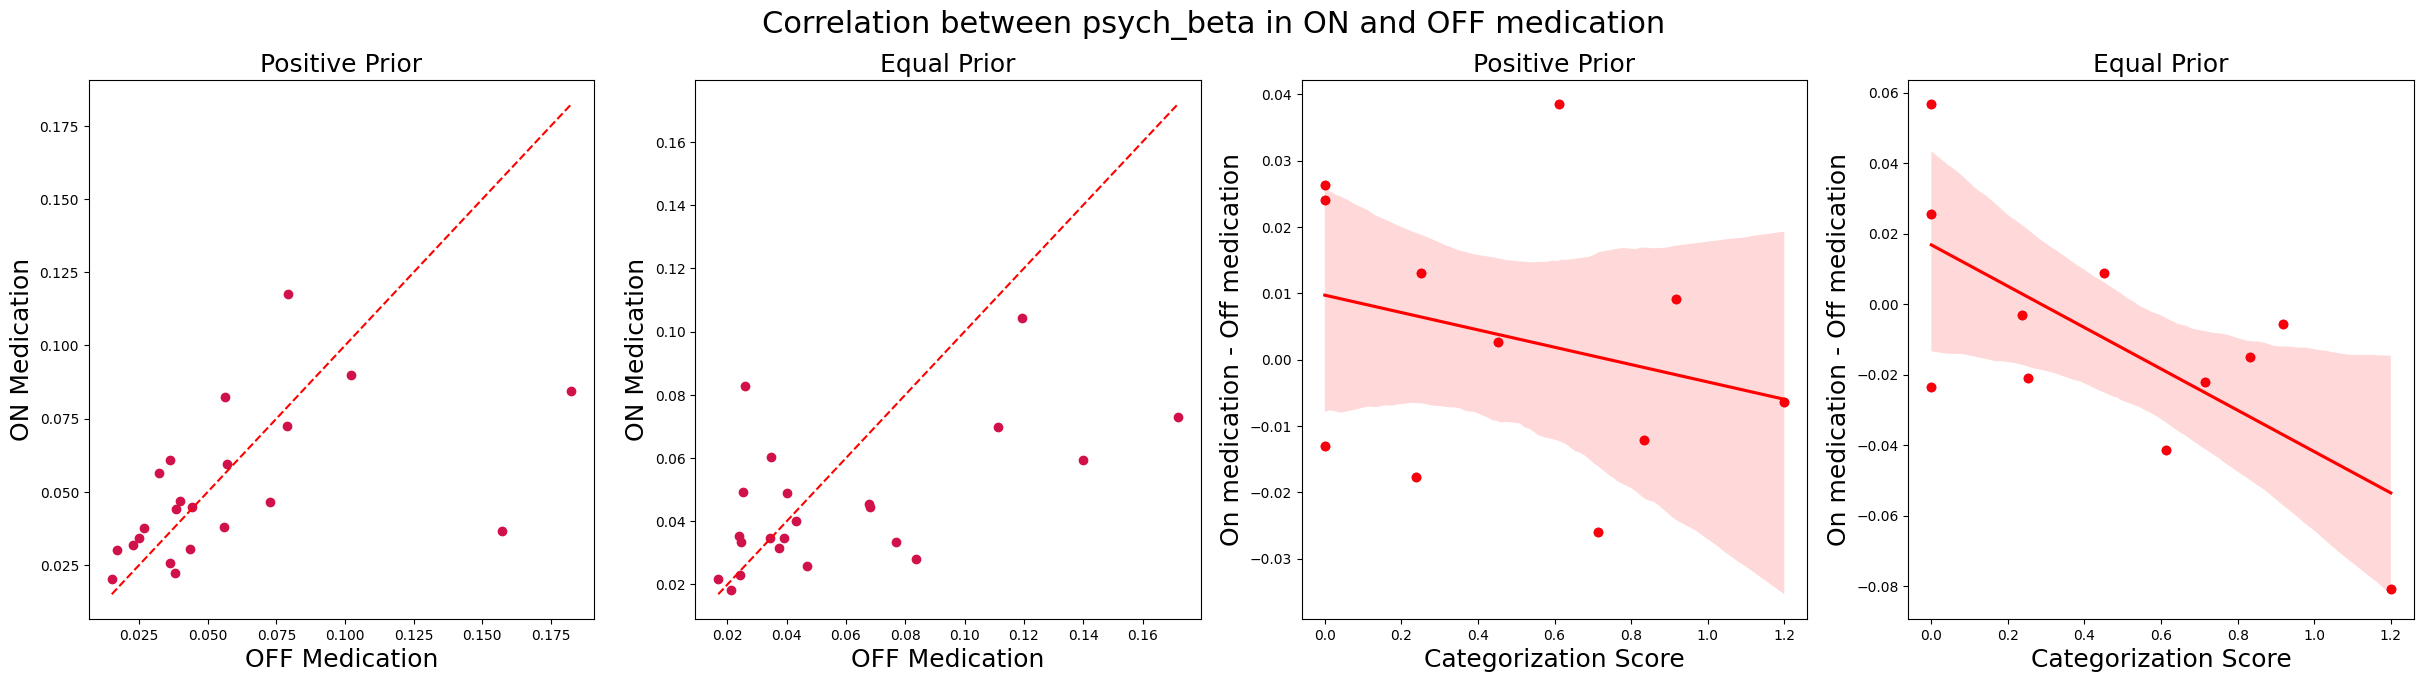

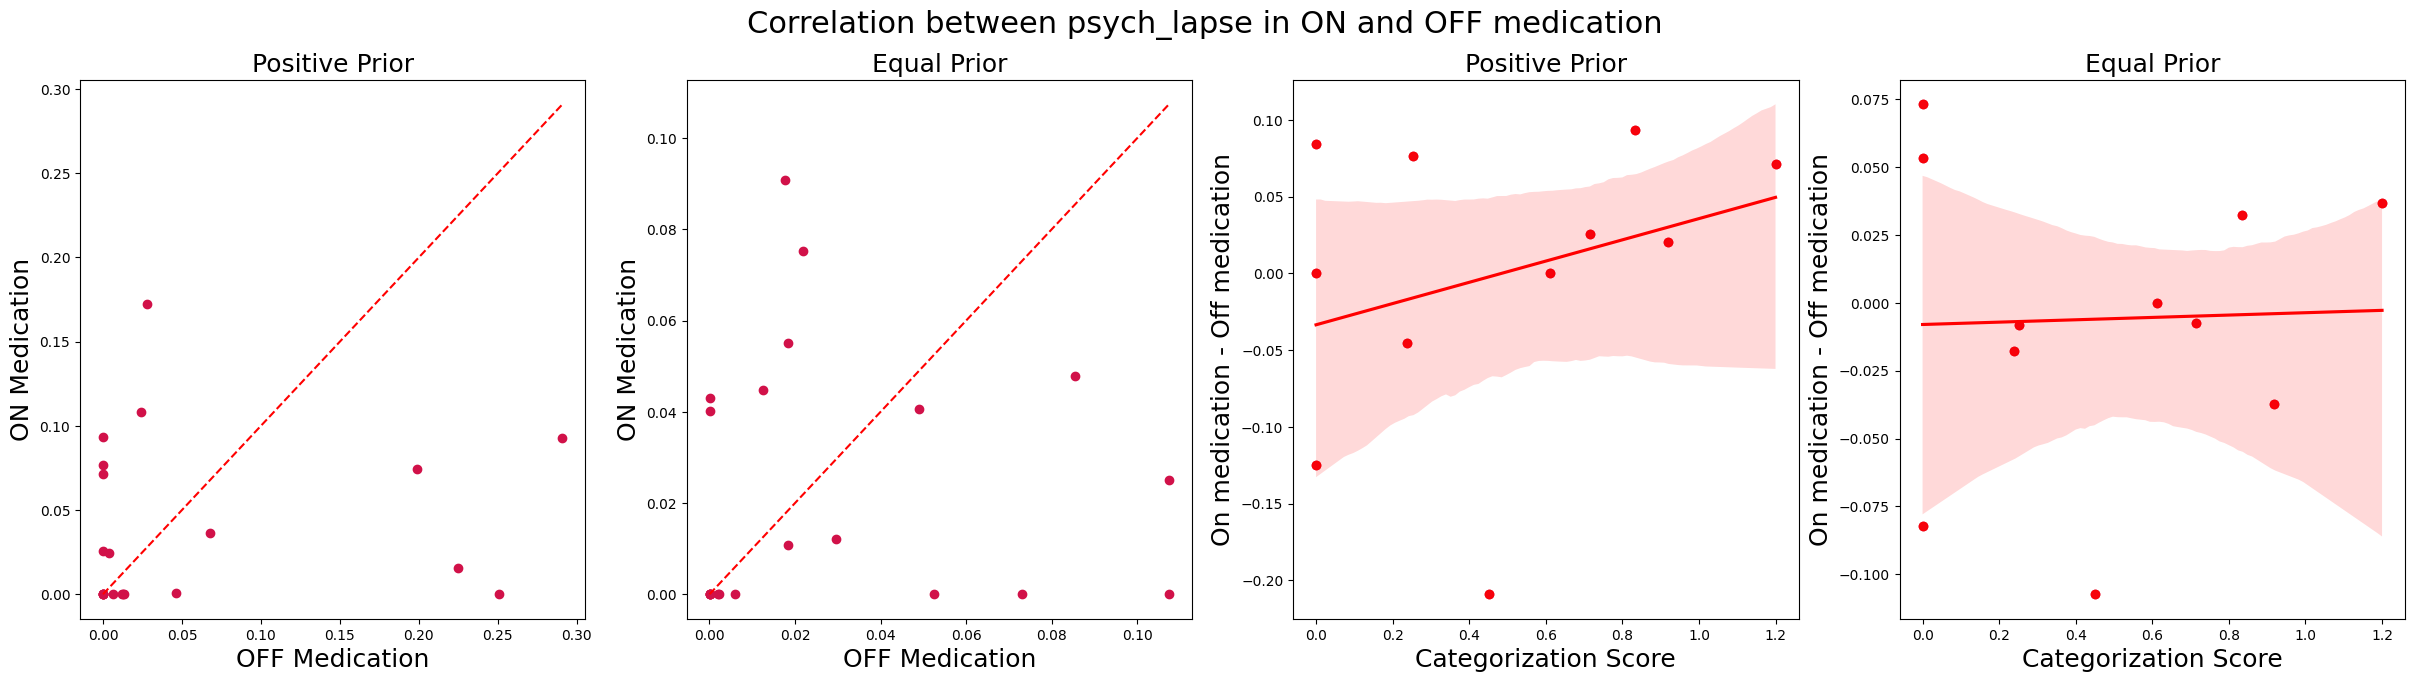

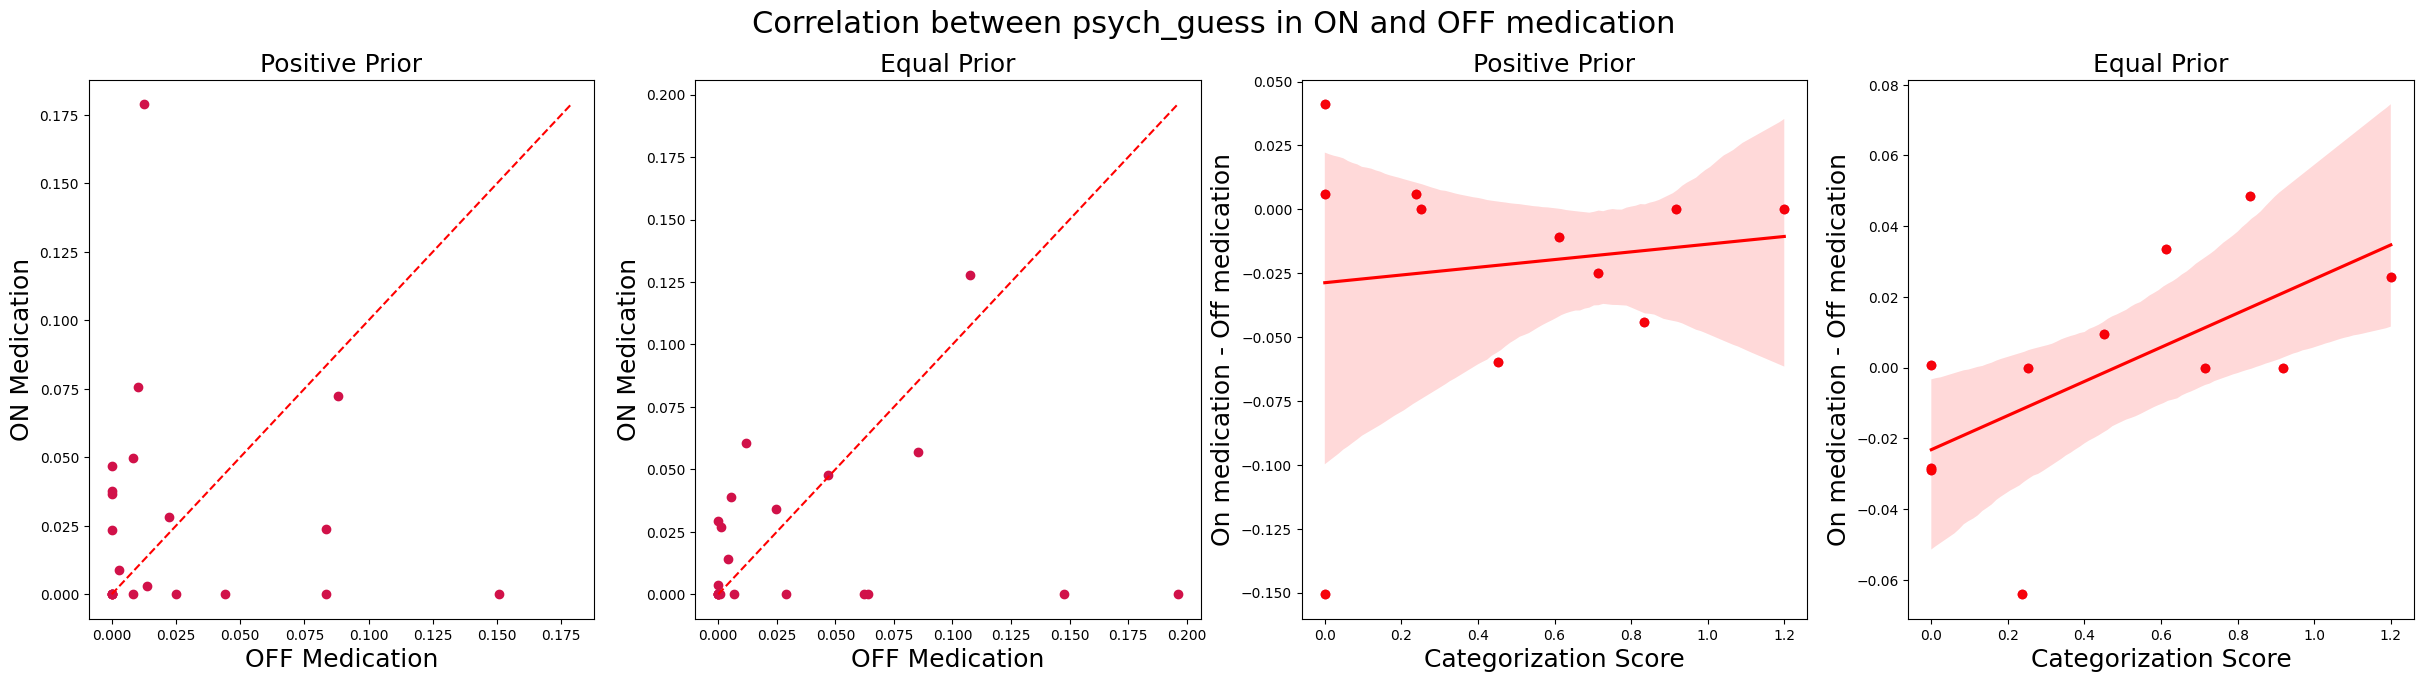

In [87]:

independent_variables = ['bias', 'psych_bias', 'psych_alpha', 'psych_beta', 'psych_lapse', 'psych_guess']

for independent_variable in independent_variables:

    fig, ax = plt.subplots(1, 4, figsize=(30, 7))
    ax[0].scatter(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'], processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'])
    # get x_min, x_max, y_min, y_max
    x_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].min())
    x_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].max())
    y_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].min())
    y_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].max())
    ax[0].plot([x_min, x_max], [y_min, y_max], 'r--')
    ax[0].set_xlabel('OFF Medication', fontsize=18)
    ax[0].set_ylabel('ON Medication', fontsize=18)
    ax[0].set_title('Positive Prior', fontsize=18)

    ax[1].scatter(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'], processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'])
    # get x_min, x_max, y_min, y_max
    x_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].min())
    x_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].max())
    y_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].min())
    y_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].max())
    ax[1].plot([x_min, x_max], [y_min, y_max], 'r--')
    ax[1].set_xlabel('OFF Medication', fontsize=18)
    ax[1].set_ylabel('ON Medication', fontsize=18)
    ax[1].set_title('Equal Prior', fontsize=18)
    
    positive_diff = processed_metadata.loc[subtype_idx['on']][f'positive_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'positive_{independent_variable}'].values
    ax[2].scatter(processed_metadata.loc[subtype_idx['off']]['categorization_score'], positive_diff)
    x_min = processed_metadata.loc[subtype_idx['off']]['categorization_score'].min()
    x_max = processed_metadata.loc[subtype_idx['off']]['categorization_score'].max()
    y_min = positive_diff.min()
    y_max = positive_diff.max()
    # plot regression line for the scatter plot
    sns.regplot(x=processed_metadata.loc[subtype_idx['off']]['categorization_score'], y=positive_diff, ax=ax[2], color='r')
    ax[2].set_xlabel('Categorization Score', fontsize=18)
    ax[2].set_ylabel('On medication - Off medication', fontsize=18)
    ax[2].set_title('Positive Prior', fontsize=18)
    
    equal_diff = processed_metadata.loc[subtype_idx['on']][f'equal_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'equal_{independent_variable}'].values
    ax[3].scatter(processed_metadata.loc[subtype_idx['off']]['categorization_score'], equal_diff)
    x_min = processed_metadata.loc[subtype_idx['off']]['categorization_score'].min()
    x_max = processed_metadata.loc[subtype_idx['off']]['categorization_score'].max()
    y_min = equal_diff.min()
    y_max = equal_diff.max()
    # plot regression line for the scatter plot
    sns.regplot(x=processed_metadata.loc[subtype_idx['off']]['categorization_score'], y=equal_diff, ax=ax[3], color='r')
    ax[3].set_xlabel('Categorization Score', fontsize=18)
    ax[3].set_ylabel('On medication - Off medication', fontsize=18)
    ax[3].set_title('Equal Prior', fontsize=18)

    supertitle = f"Correlation between {independent_variable} in ON and OFF medication"
    fig.suptitle(supertitle, fontsize=22)

### Statistical Testing

In [148]:
vars = ['positive_bias', 'positive_psych_bias', 'positive_psych_alpha', 'positive_psych_beta', 'positive_psych_lapse', 'positive_psych_guess', 
        'equal_bias', 'equal_psych_bias', 'equal_psych_alpha', 'equal_psych_beta', 'equal_psych_lapse', 'equal_psych_guess']


for var in vars:
    positive_diff = processed_metadata.loc[subtype_idx['on']][var].values - processed_metadata.loc[subtype_idx['off']][var].values
    pos_psych_model = sm.OLS(positive_diff, processed_metadata.loc[subtype_idx['off']]['categorization_score']).fit()
    pos_psych_model.summary()
    print(f"{var}: \t p-value: {pos_psych_model.pvalues[0].round(4)} \t R-squared: {pos_psych_model.rsquared.round(4)}")

positive_bias: 	 p-value: 0.8681 	 R-squared: 0.0029
positive_psych_bias: 	 p-value: 0.8764 	 R-squared: 0.0025
positive_psych_alpha: 	 p-value: 0.7267 	 R-squared: 0.0128
positive_psych_beta: 	 p-value: 0.9261 	 R-squared: 0.0009
positive_psych_lapse: 	 p-value: 0.5584 	 R-squared: 0.0354
positive_psych_guess: 	 p-value: 0.449 	 R-squared: 0.0585
equal_bias: 	 p-value: 0.5877 	 R-squared: 0.0304
equal_psych_bias: 	 p-value: 0.6493 	 R-squared: 0.0215
equal_psych_alpha: 	 p-value: 0.7297 	 R-squared: 0.0125
equal_psych_beta: 	 p-value: 0.0211 	 R-squared: 0.4275
equal_psych_lapse: 	 p-value: 0.8407 	 R-squared: 0.0042
equal_psych_guess: 	 p-value: 0.2028 	 R-squared: 0.1567
